In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data Preparation
input_dir = '/kaggle/input/face-mask-dataset/data'
working_dir = '/kaggle/working/data'  # Writable working directory
input_size = 224
batch_size = 32

# Create working directory structure
def prepare_dataset(input_dir, working_dir, val_ratio=0.2):
    os.makedirs(os.path.join(working_dir, 'train', 'with_mask'), exist_ok=True)
    os.makedirs(os.path.join(working_dir, 'train', 'without_mask'), exist_ok=True)
    os.makedirs(os.path.join(working_dir, 'val', 'with_mask'), exist_ok=True)
    os.makedirs(os.path.join(working_dir, 'val', 'without_mask'), exist_ok=True)
    
    for class_name in ['with_mask', 'without_mask']:
        src_dir = os.path.join(input_dir, class_name)
        files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
        train_files, val_files = train_test_split(files, test_size=val_ratio, random_state=42)
        
        for f in train_files:
            src_path = os.path.join(src_dir, f)
            dst_path = os.path.join(working_dir, 'train', class_name, f)
            shutil.copy2(src_path, dst_path)
        
        for f in val_files:
            src_path = os.path.join(src_dir, f)
            dst_path = os.path.join(working_dir, 'val', class_name, f)
            shutil.copy2(src_path, dst_path)

print("Preparing dataset...")
prepare_dataset(input_dir, working_dir)
print("Dataset preparation completed!")

Using device: cuda
Preparing dataset...
Dataset preparation completed!


In [4]:
# Data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# Load datasets
image_datasets = {
    x: datasets.ImageFolder(os.path.join(working_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4
    )
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print("\nDataset Information:")
print(f"Classes: {class_names}")
print(f"Number of training images: {dataset_sizes['train']}")
print(f"Number of validation images: {dataset_sizes['val']}")

# Model Building
def build_model(num_classes=2):
    model = models.mobilenet_v2(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    return model


Dataset Information:
Classes: ['with_mask', 'without_mask']
Number of training images: 6042
Number of validation images: 1511


In [6]:
model = build_model(len(class_names))
model = model.to(device)
print("\nModel architecture:")
print(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 169MB/s]



Model architecture:
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1):

In [7]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'val':
                epoch_precision = precision_score(all_labels, all_preds, average='weighted')
                epoch_recall = recall_score(all_labels, all_preds, average='weighted')
                epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
                
                history['precision'].append(epoch_precision)
                history['recall'].append(epoch_recall)
                history['f1'].append(epoch_f1)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history


Starting training...

Epoch 1/20
----------
Train Loss: 0.3452 Acc: 0.8577
Val Loss: 0.1214 Acc: 0.9656

Epoch 2/20
----------
Train Loss: 0.2657 Acc: 0.8870
Val Loss: 0.0991 Acc: 0.9682

Epoch 3/20
----------
Train Loss: 0.2451 Acc: 0.8944
Val Loss: 0.0780 Acc: 0.9755

Epoch 4/20
----------
Train Loss: 0.2474 Acc: 0.8956
Val Loss: 0.0731 Acc: 0.9782

Epoch 5/20
----------
Train Loss: 0.2413 Acc: 0.9000
Val Loss: 0.0723 Acc: 0.9762

Epoch 6/20
----------
Train Loss: 0.2294 Acc: 0.9050
Val Loss: 0.0824 Acc: 0.9729

Epoch 7/20
----------
Train Loss: 0.2291 Acc: 0.9024
Val Loss: 0.0779 Acc: 0.9722

Epoch 8/20
----------
Train Loss: 0.2395 Acc: 0.8979
Val Loss: 0.0715 Acc: 0.9755

Epoch 9/20
----------
Train Loss: 0.2213 Acc: 0.9086
Val Loss: 0.0695 Acc: 0.9768

Epoch 10/20
----------
Train Loss: 0.2301 Acc: 0.9047
Val Loss: 0.0702 Acc: 0.9755

Epoch 11/20
----------
Train Loss: 0.2115 Acc: 0.9103
Val Loss: 0.0764 Acc: 0.9768

Epoch 12/20
----------
Train Loss: 0.2113 Acc: 0.9103
Val Loss

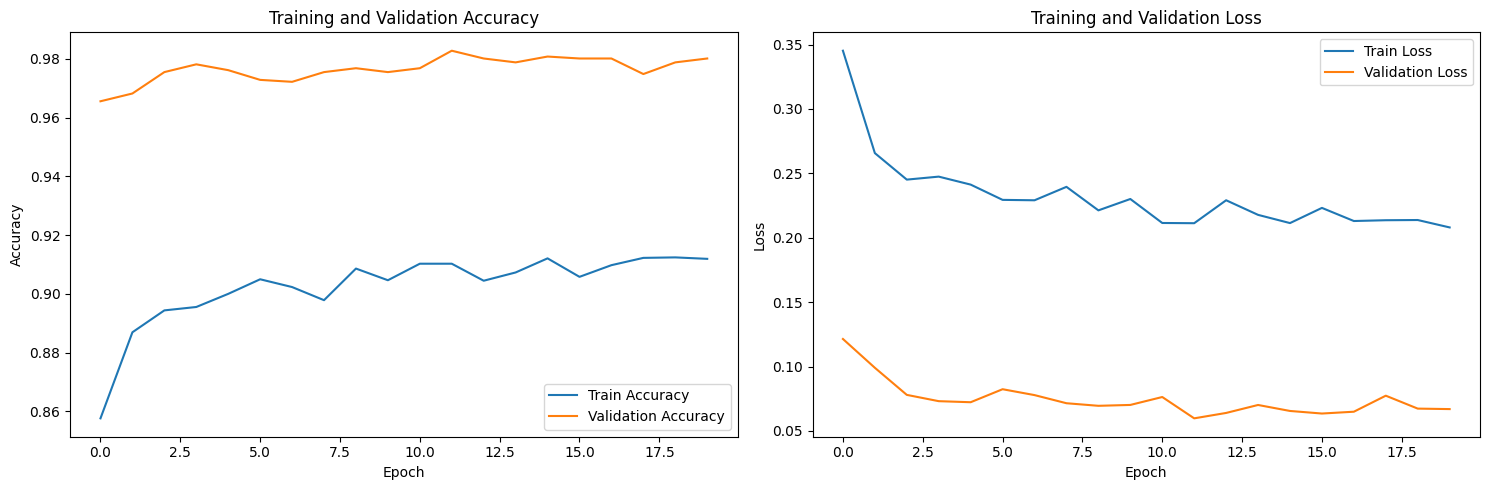

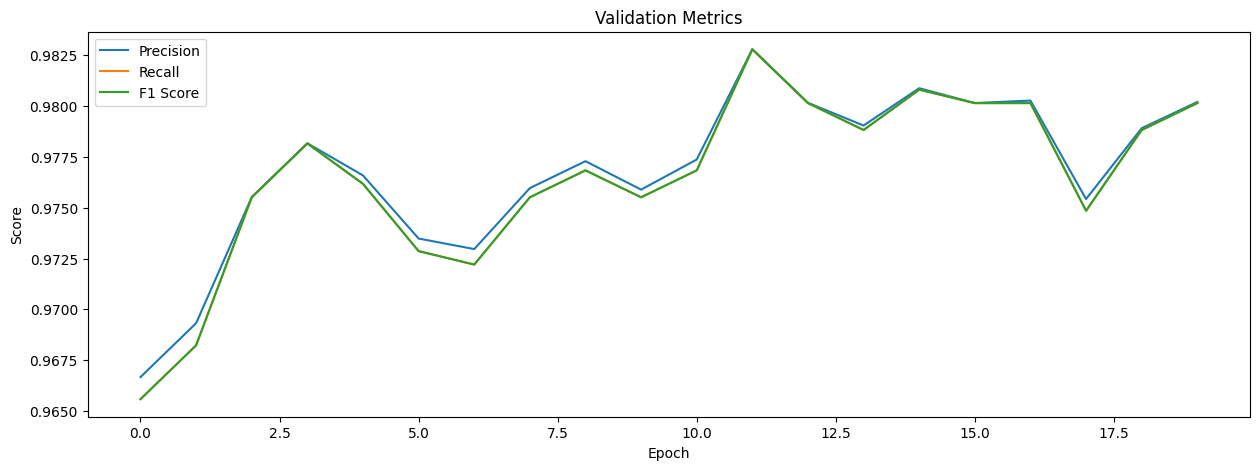

In [8]:
# Training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
num_epochs = 20
print("\nStarting training...")
model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

# Plot training history
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Metrics plot
plt.figure(figsize=(15, 5))
plt.plot(history['precision'], label='Precision')
plt.plot(history['recall'], label='Recall')
plt.plot(history['f1'], label='F1 Score')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.show()


Validation Set Evaluation:


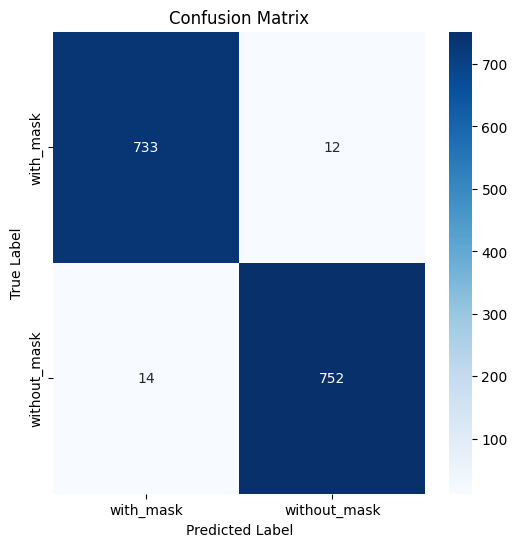


Classification Report:
              precision    recall  f1-score   support

   with_mask     0.9813    0.9839    0.9826       745
without_mask     0.9843    0.9817    0.9830       766

    accuracy                         0.9828      1511
   macro avg     0.9828    0.9828    0.9828      1511
weighted avg     0.9828    0.9828    0.9828      1511


Model saved as '/kaggle/working/face_mask.pth'


In [9]:
# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    return all_preds, all_labels

print("\nValidation Set Evaluation:")
val_preds, val_labels = evaluate_model(model, dataloaders['val'])

# Save the model
model_path = '/kaggle/working/face_mask.pth'
torch.save(model.state_dict(), model_path)
print(f"\nModel saved as '{model_path}'")

In [10]:
# Prediction function for new images
def predict_image(image_path, model, transform):
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
    
    plt.imshow(image)
    plt.title(f'Predicted: {class_names[preds[0]]} ({probs[preds[0]].item():.1f}%)')
    plt.axis('off')
    plt.show()
    
    return class_names[preds[0]], probs[preds[0]].item()


Testing on image: /kaggle/input/face-mask-dataset/data/with_mask/with_mask_1007.jpg


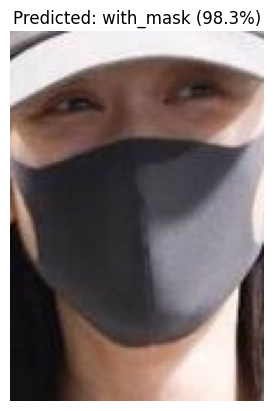

Prediction: with_mask with 98.3% confidence


In [11]:
# Test the model on a new image
test_image_path = '/kaggle/input/face-mask-dataset/data/with_mask/with_mask_1007.jpg' 
if os.path.exists(test_image_path):
    print(f"\nTesting on image: {test_image_path}")
    prediction, confidence = predict_image(test_image_path, model, data_transforms['val'])
    print(f"Prediction: {prediction} with {confidence:.1f}% confidence")
else:
    print("\nNo test image found. To test the model, please provide a valid image path.")


Testing on image: /kaggle/input/face-mask-dataset/data/without_mask/without_mask_1019.jpg


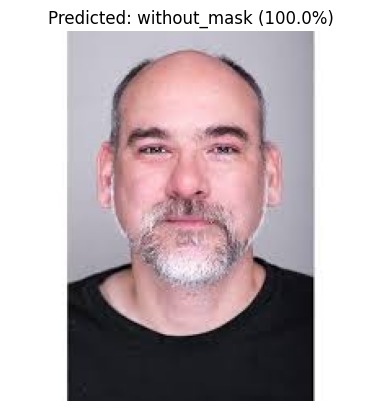

Prediction: without_mask with 100.0% confidence


In [12]:
# Test the model on a new image
test_image_path = '/kaggle/input/face-mask-dataset/data/without_mask/without_mask_1019.jpg' 
if os.path.exists(test_image_path):
    print(f"\nTesting on image: {test_image_path}")
    prediction, confidence = predict_image(test_image_path, model, data_transforms['val'])
    print(f"Prediction: {prediction} with {confidence:.1f}% confidence")
else:
    print("\nNo test image found. To test the model, please provide a valid image path.")